In [287]:
%%bigquery schema --table "dancedeets-hrd:dance_events.dance_events"

# Popular Dance Styles


In [93]:
%%sql --module styles
SELECT auto_categories, COUNT(auto_categories) as count
FROM [dancedeets-hrd:dance_events.dance_events]
WHERE auto_categories in ('BREAK', 'HIPHOP', 'HOUSE', 'POP', 'LOCK', 'WAACK', 'DANCEHALL', 'VOGUE', 'KRUMP', 'ALLSTYLE')
GROUP BY auto_categories
ORDER BY count DESC
LIMIT 10

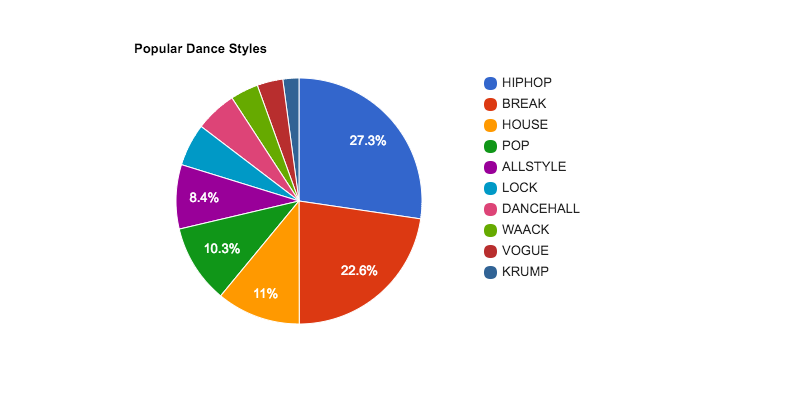

In [119]:
%%chart pie --fields auto_categories,count --data styles
title: "Popular Dance Styles"
width: 800
height: 400

# Popular Countries

In [115]:
%%sql --module countries
SELECT country, COUNT(country) as count
FROM [dancedeets-hrd:dance_events.dance_events]
GROUP BY country
ORDER BY count DESC
LIMIT 10

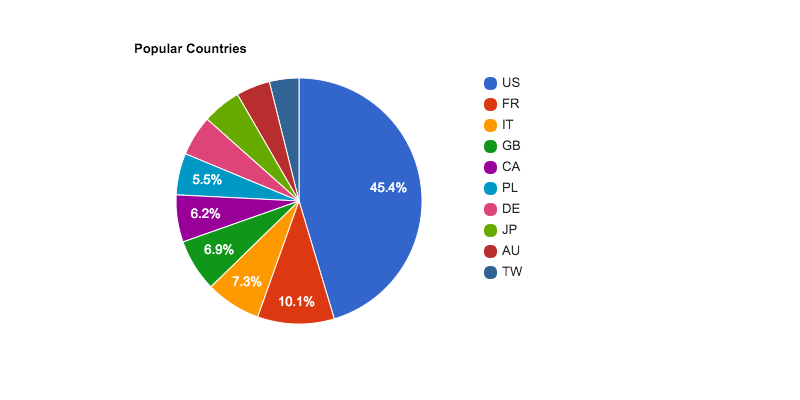

In [121]:
%%chart pie --fields country,count --data countries
title: "Popular Countries"
width: 800
height: 400

# Events Taking Place over Time

In [69]:
%%sql --module date_held
SELECT YEAR(start_time) + WEEK(start_time)/52 as date, COUNT(*) as count
FROM [dancedeets-hrd:dance_events.dance_events]
WHERE start_time > '2010-06-01 00:00' AND start_time < CURRENT_TIMESTAMP()
GROUP BY date ORDER BY date;

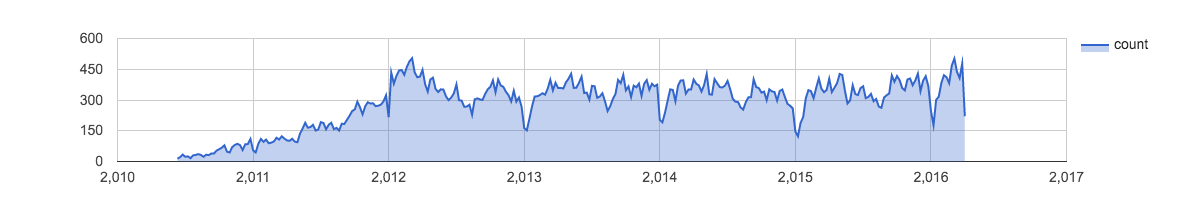

In [123]:
%%chart area --fields date,count --data date_held
hAxis: {
    ticks: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
}

# Events Planned in the Future

In [72]:
%%sql --module date_held_future
SELECT YEAR(start_time) + WEEK(start_time)/52 as date, COUNT(*) as count
FROM [dancedeets-hrd:dance_events.dance_events]
WHERE start_time > CURRENT_TIMESTAMP() AND start_time < DATE_ADD(CURRENT_TIMESTAMP(), 1, "YEAR")
GROUP BY date ORDER BY date;

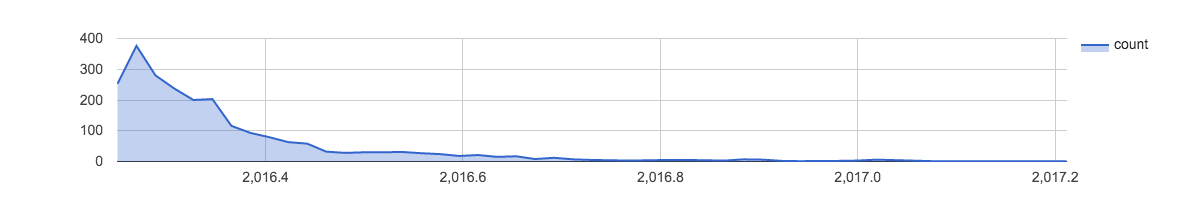

In [108]:
%%chart area --fields date,count --data date_held_future


# Dates Added to DanceDeets by Time

In [285]:
%%sql --module date_added
SELECT YEAR(creation_time) + WEEK(creation_time)/52 as date, IF(COUNT(*) < 1000,COUNT(*),1000) as count
FROM [dancedeets-hrd:dance_events.dance_events]
WHERE creation_time > '2010-06-01 00:00'
GROUP BY date ORDER BY date;

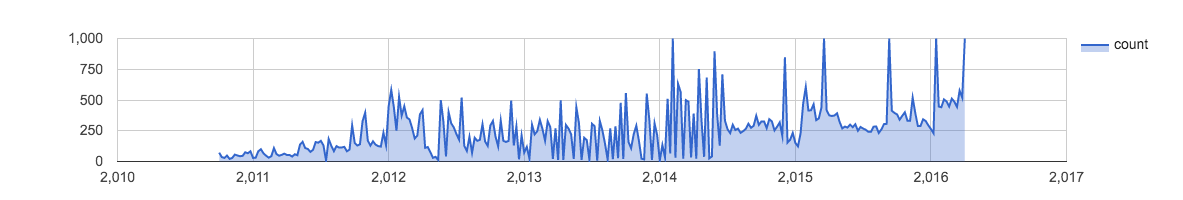

In [286]:
%%chart area --fields date,count --data date_added
hAxis: {
    ticks: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
}


# Top Event Submitters

In [223]:
%%bigquery execute
// Top Event Submittors
SELECT creating_fb_uid, COUNT(*) as count FROM dance_events.dance_events group by creating_fb_uid order by count DESC LIMIT 15;


creating_fb_uid,count
0,48202
,25633
701004,16897
12126355,128
844834189,41
10202865886561351,32
650920953,30
1227780292,26
1018460109,24
100000912398353,21


# Top Event Organizers/Promoters

In [226]:
%%bigquery execute
// Top Event Submittors
SELECT owner_fb_uid, COUNT(*) as count FROM dance_events.dance_events group by owner_fb_uid order by count DESC LIMIT 15;


owner_fb_uid,count
,6249
781897710751,213
82875672121,199
312983955496420,132
149053998118,132
124298037585719,109
1057745694,109
10202650357594465,107
10154804270000655,106
176361129066169,105


# Most Common Attendee Counts

In [280]:
%%sql --module attendee_buckets
SELECT FLOOR(attendee_count/5)*5 as rounded_attendee, count(*) as count
FROM dance_events.dance_events
group by rounded_attendee order by rounded_attendee
LIMIT 100;


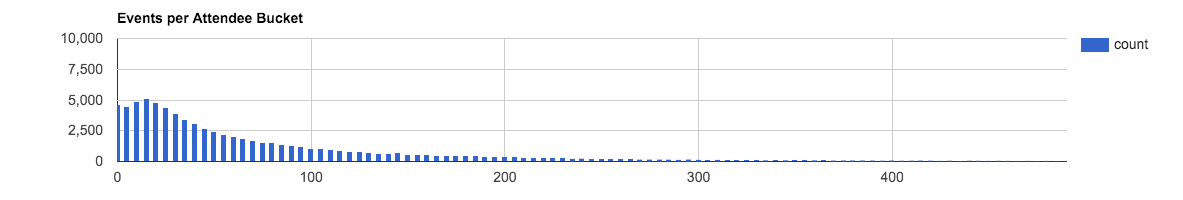

In [282]:
%%chart columns --data attendee_buckets
title: Events per Attendee Bucket
vAxis: {
    logScale: false
  }

# Most Common Cities

In [218]:
%%sql --module geo

DEFINE QUERY locations
  SELECT FLOAT(latitude) AS lat, FLOAT(longitude) AS lon, __key__.name as id, city_name
  FROM [dancedeets-hrd:dance_events.dance_events]
  WHERE latitude is NOT NULL

DEFINE QUERY hotspots_temp
  SELECT FIRST(lat) AS lat, FIRST(lon) AS lon, CONCAT(FIRST(city_name), ': ', STRING(COUNT(id)), ' events') AS title, COUNT(id) as event_count
  FROM $locations
  GROUP BY city_name
  ORDER BY event_count DESC
  LIMIT 20


In [219]:
%%chart map --fields lat,lon,title --data geo
showTip: true
mapType: normal

In [220]:
%%bigquery execute --query geo

lat,lon,title,event_count
47.4824527,8.310524,Unknown: 7462 events,7462
40.7385925,-73.9897568,"New York City, United States: 6011 events",6011
37.7799055,-122.1816552,"San Francisco Bay Area, United States: 2967 events",2967
48.8598208,2.3508789,"Paris, France: 2443 events",2443
44.9697994,-93.2848184,,1908
34.1137361,-118.3356085,"Los Angeles, United States: 1883 events",1883
51.5269228,-0.1286164,"City of London, United Kingdom: 1800 events",1800
35.3405091,139.4928024,"Tokyo, Japan: 1771 events",1771
25.091075,121.5598345,"Taipei, Taiwan: 1308 events",1308
-33.877606,151.205457,"Sydney, Australia: 1234 events",1234


# User Signups by Date

In [293]:
%%sql --module user_joined
SELECT YEAR(creation_time) + WEEK(creation_time)/52 as date, COUNT(*) as count
FROM [dancedeets-hrd:dance_events.users]
WHERE creation_time > '2010-06-01 00:00'
GROUP BY date ORDER BY date;

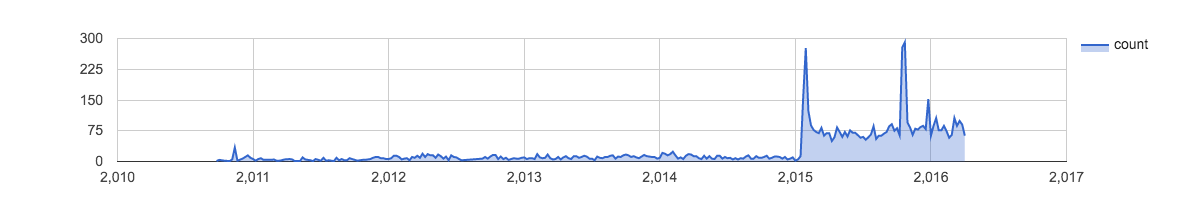

In [294]:
%%chart area --fields date,count --data user_joined
hAxis: {
    ticks: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
}


# User Signups by Date (After Mobile Launch and Stronger Website Push)

In [295]:
%%sql --module user_joined
SELECT YEAR(creation_time) + WEEK(creation_time)/52 as date, COUNT(*) as count
FROM [dancedeets-hrd:dance_events.users]
WHERE creation_time > '2015-01-01 00:00'
GROUP BY date ORDER BY date;

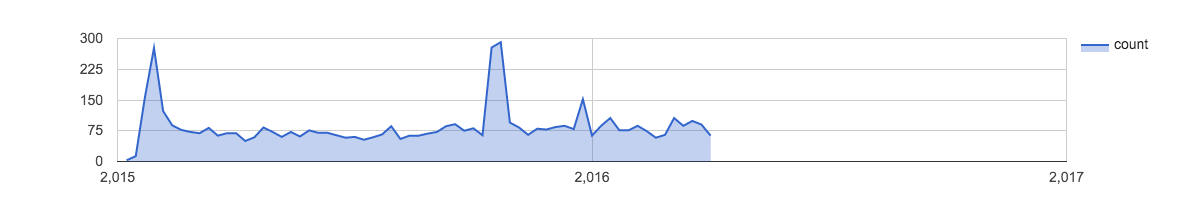

In [297]:
%%chart area --fields date,count --data user_joined
hAxis: {
    ticks: [2015, 2016, 2017]
}


# Active Users

In [319]:
import gcp.bigquery as bq
valid = bq.Query(
  '''SELECT COUNT(expired_oauth_token) as count
   FROM [dancedeets-hrd:dance_events.users]
   WHERE expired_oauth_token == False''').results()[0]['count']
total = bq.Query(
    '''SELECT COUNT(expired_oauth_token) as count
     FROM [dancedeets-hrd:dance_events.users]''').results()[0]['count']

"%s (%2.0f%% of total) users are active in last 60 days" % (valid, 100.0*valid/total)


'2090 (28% of total) users are active in last 60 days'

# Percentage of Users Accessed/Signedup within last N days

In [357]:
%%sql --module user_accessed
SELECT ROW_NUMBER() OVER (ORDER BY access_time) AS percentile, access_time
FROM (
  SELECT
  QUANTILES(DATEDIFF(CURRENT_TIMESTAMP(), last_login_time), 100) AS access_time
  FROM [dancedeets-hrd:dance_events.users]
)
SELECT ROW_NUMBER() OVER (ORDER BY creation_time) AS percentile, creation_time
FROM (
  SELECT
  QUANTILES(DATEDIFF(CURRENT_TIMESTAMP(), creation_time), 100) AS creation_time
  FROM [dancedeets-hrd:dance_events.users]
)


In [358]:
%%chart columns --data user_accessed --fields percentile,access_time,creation_time
vAxis: {
  scaleType: 'log'
}

Cannot query the cross product of repeated fields access_time and creation_time. 


Things that would be nice to have in DBEvent:
- event privacy
- has image?
- location_name / venue name
- city
- state
- admin ids/names
